<a href="https://colab.research.google.com/github/sebfoe/cloud_computing_2023/blob/main/STAC/Data_from_AWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b> Data from AWS <b/>

Loading data from AWS can be done by using [open S3 buckets](https://registry.opendata.aws/sentinel-2-l2a-cogs/) from [element84](https://www.element84.com/).

May you need to install some packages in your environment. You can do this via adding additional cells and cell magic in Jupyter Notebook like

`!pip install <PACKAGE1> <PACKAGE2>`

### Load needed packages and functions

In [1]:
import dask.distributed
import folium
import folium.plugins
import geopandas as gpd
import odc.ui
import shapely.geometry
import yaml
from branca.element import Figure
from IPython.display import HTML, display
from odc.algo import to_rgba
from pystac_client import Client

from odc.stac import configure_rio, stac_load

def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))


You can define configurations when loading data from S3

In [2]:
cfg = """---
sentinel-s2-l2a-cogs:
  assets:
    '*':
      data_type: uint16
      nodata: 0
      unit: '1'
    SCL:
      data_type: uint8
      nodata: 0
      unit: '1'
    visual:
      data_type: uint8
      nodata: 0
      unit: '1'
  aliases:  # Alias -> Canonical Name
    swir2: B12
    swir1: B11
    water_vapour: B09
    narrow_nir: B8A
    nir: B08
    red_edge3: B06
    red_edge2: B06
    red_edge1: B05
    red: B04
    green: B03
    blue: B02
    coastal_aersosl: B01
"*":
  warnings: ignore # Disable warnings about duplicate common names
"""
cfg = yaml.load(cfg, Loader=yaml.SafeLoader)

### Dask
Optional step which can speed up processing. See [DASK](https://www.dask.org/) for more information.

client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

Find items

In [3]:
# build bounding box
km2deg = 1.0 / 111
x, y = (9, 49)  # Center point of a query
r = 100 * km2deg
bbox = (x - r, y - r, x + r, y + r)

In [4]:
# connect to catalog
catalog = Client.open("https://earth-search.aws.element84.com/v0")
# define a query
query = catalog.search(
    collections=["sentinel-s2-l2a-cogs"], datetime="2022-07-15", bbox=bbox
)
# show itesm
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection for usage as vector information
stac_json = query.get_all_items_as_dict()

Found: 6 datasets


### Review the results

In [5]:
# write stac_json to geopandas daatframe
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
# extract id from granule
# Compute granule id from components
gdf["granule"] = (
    gdf["sentinel:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["sentinel:latitude_band"]
    + gdf["sentinel:grid_square"]
)

Plot the resulting tiles

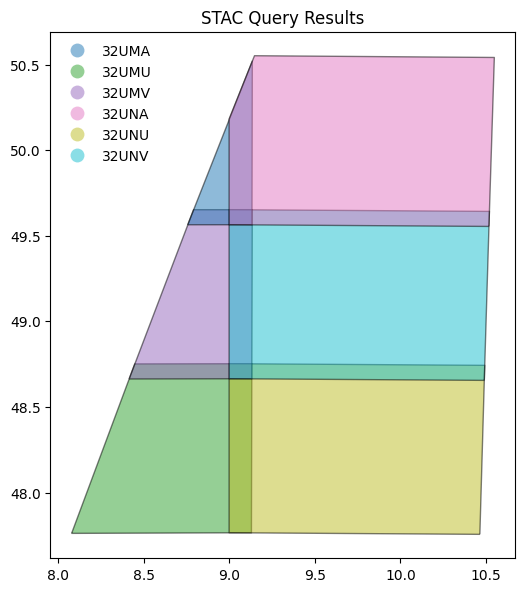

In [6]:
fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")


Or, for better orientation on a map

In [7]:
# https://github.com/python-visualization/folium/issues/1501
fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "sentinel:data_coverage",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

### Construct a Dask dataset, i.e. lazy laoding

In [8]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

ds = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=cfg,
)
display(ds)

<xarray.Dataset>
Dimensions:      (y: 1489, x: 860, time: 1)
Coordinates:
  * y            (y) float64 6.543e+06 6.542e+06 ... 6.067e+06 6.066e+06
  * x            (x) float64 8.994e+05 8.997e+05 9e+05 ... 1.174e+06 1.174e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2022-07-15T10:27:06
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1489, 860), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1489, 860), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1489, 860), meta=np.ndarray>

In [9]:
%%time
rgba = to_rgba(ds, clamp=(1, 3000))
_rgba = rgba.compute()


/home/UNI-WUERZBURG.EU/sef35id/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 598 ms, sys: 80.4 ms, total: 678 ms
Wall time: 6.56 s


### Plot the RGB on a map


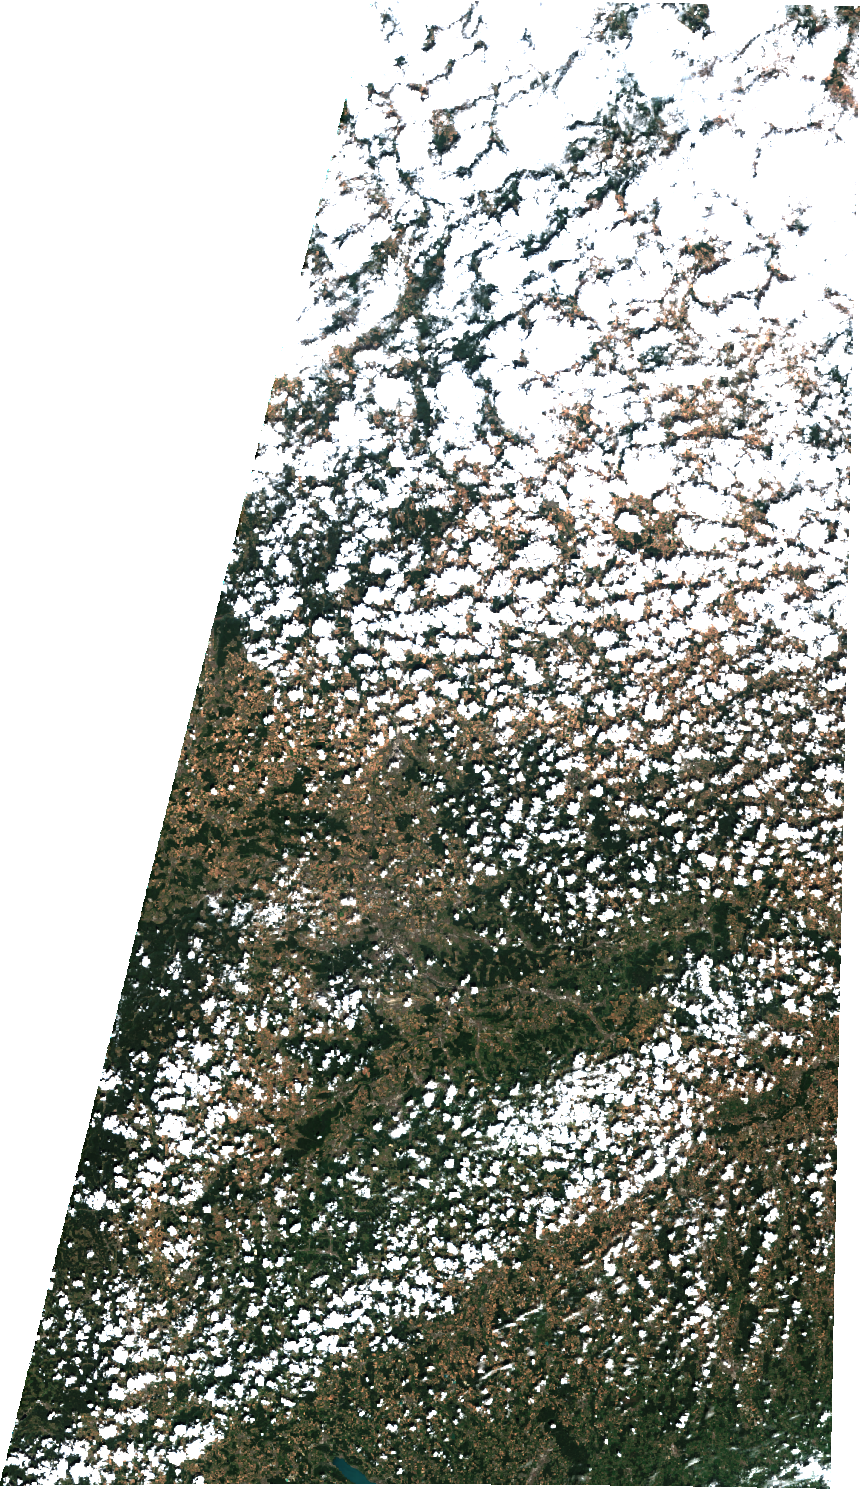

In [10]:
map2 = folium.Map()

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map2)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "sentinel:data_coverage",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map2,
)


# Image bounds are specified in Lat/Lon order with Lat axis inversed
image_bounds = convert_bounds(_rgba.geobox.geographic_extent.boundingbox, invert_y=True)
img_ovr = folium.raster_layers.ImageOverlay(
    _rgba.isel(time=0).data, bounds=image_bounds, name="Image"
)
img_ovr.add_to(map2)
map2.fit_bounds(bounds=image_bounds)

folium.LayerControl().add_to(map2)
folium.plugins.Fullscreen().add_to(map2)
map2

### Load smaller extents

In [11]:
r = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)

yy = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=cfg,
    bbox=small_bbox,
)
im_small = to_rgba(yy, clamp=(1, 3000)).compute()

In [12]:
img_zoomed_in = odc.ui.mk_data_uri(
    odc.ui.to_jpeg_data(im_small.isel(time=0).data, quality=80), "image/jpeg"
)
print(f"Image url: {img_zoomed_in[:64]}...")

Image url: data:image/jpeg;base64,/9j/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQOD...


Warning 1: 4-band JPEGs will be interpreted on reading as in CMYK colorspace



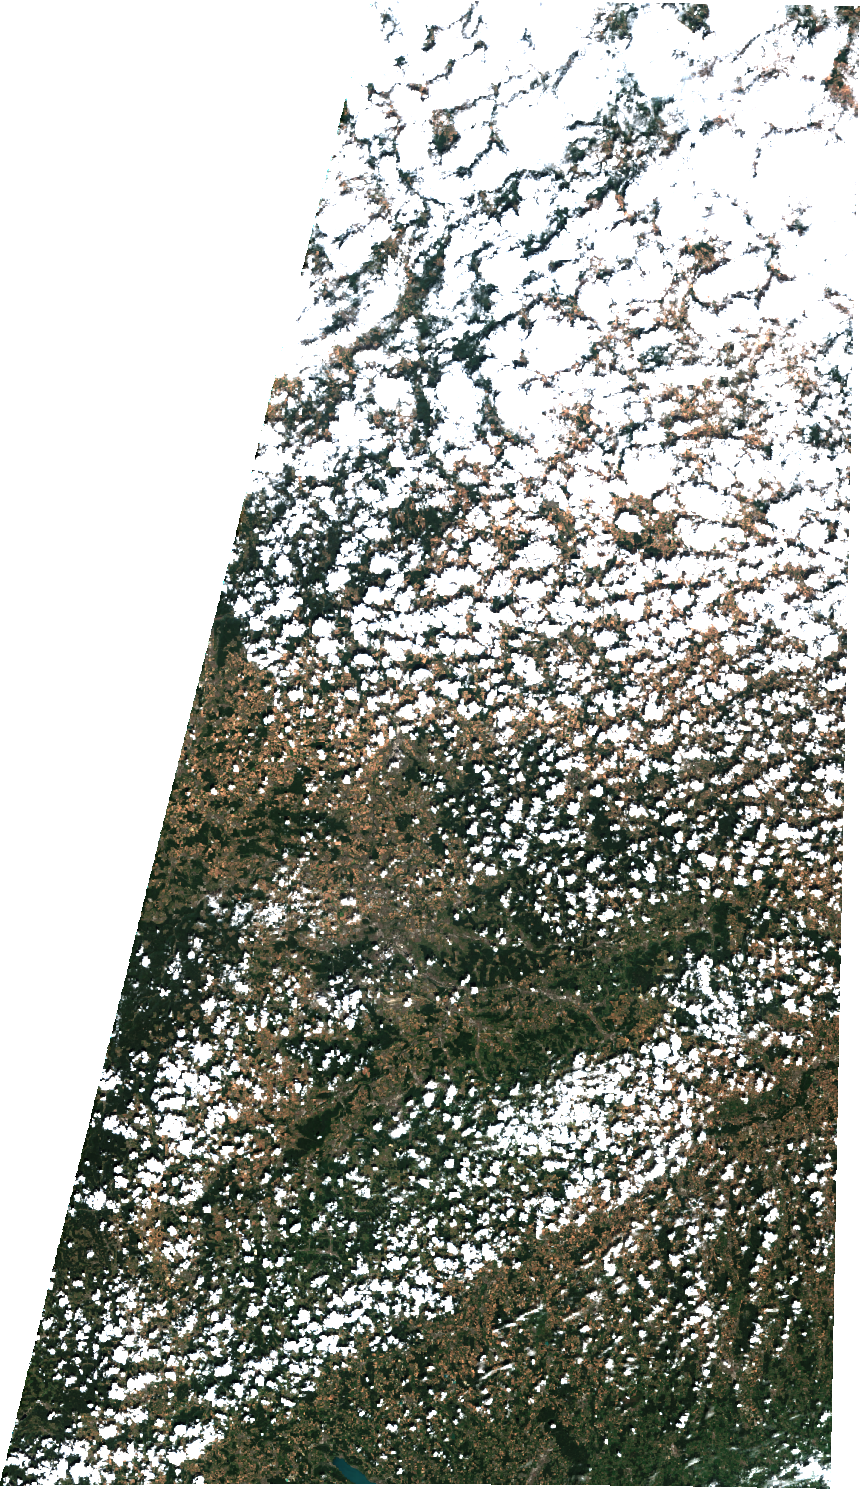

In [13]:
HTML(
    data=f"""
<style> .img-two-column{{
  width: 50%;
  float: left;
}}</style>
<img src="{img_zoomed_in}" alt="Sentinel-2 Zoom in" class="img-two-column">
<img src="{img_ovr.url}" alt="Sentinel-2 Mosaic" class="img-two-column">
"""
)
